# Setup

In [ ]:
%%capture
!pip install transformers datasets transformers[sentencepiece]

from google.colab import drive  
drive.mount("/content/drive")

In [ ]:
from typing import Any, Dict, Tuple

from torch.utils.checkpoint import checkpoint  # See https://github.com/huggingface/transformers/issues/9919

from transformers.utils import logging
logging.set_verbosity_error()

In [ ]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

import numpy as np, pandas as pd
from datasets import Dataset, DatasetDict


class AbstractDatahandlerMixin:
    def get_tokenize_fn(self):
        raise NotImplementedError

    def get_dataset(self, dataset_kwargs: dict) -> DatasetDict:
        raise NotImplementedError


class Group67DatahandlerMixin(AbstractDatahandlerMixin):
    SPLITS = ["train", "dev", "test"]
    NAMES = ["id", "label", "text"]

    def load_split(self, path: str, label_mappings: dict) -> Dataset:
        df = pd.read_csv(path, sep="\t", header=None, names=self.NAMES)

        if label_mappings == None:
            label_mappings = {l: i for i, l in enumerate(sorted(list(set(df["label"]))))}

        df["label"] = df["label"].map(label_mappings)

        dataset = Dataset.from_pandas(df).map(self.tokenize_function, batched=True)
        dataset.remove_columns(["id", "text"])
        return dataset, label_mappings

    def get_dataset(self, dataset_kwargs: dict) -> DatasetDict:
        base_data_dir: str = dataset_kwargs["base_data_dir"]
        group_num: str = dataset_kwargs["group_num"]
        data_dir = f"{base_data_dir}/{group_num}"

        d, label_mappings = dict(), None
        for s in self.SPLITS:
            d[s], label_mappings = self.load_split(f"{data_dir}/{s}.txt", label_mappings)

        dataset = DatasetDict(d)

        labels = dataset["train"]["label"]
        class_counts = Counter(labels)
        self.class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
        print("Weighting classes using:")
        for label, idx in label_mappings.items():
            print(f"Label {label} | Count {class_counts[idx]} | Weight {self.class_weights[idx]:.3f}")

        self.label_mappings: dict = label_mappings

        return dataset

    def get_tokenize_fn(self):
        def tokenize_fn(examples):
            text = [e.split("[SEP]") for e in examples["text"]]

            # If the parent comment is the same as the title, the title is duplicated
            title, child_comment = [t[0] + t[1] for t in text], [t[2] for t in text]
            return self.tokenizer(title, child_comment, max_length=250, truncation=True)

        return tokenize_fn


In [ ]:
import torch
from torch import nn

import numpy as np
from datasets import load_metric

from transformers import AutoModelForSequenceClassification, Trainer


class AbstractDatatypeMixin:
    class DatatypeTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            raise NotImplementedError


    def get_metrics_fn(self):
        raise NotImplementedError

    def get_model(self):
        raise NotImplementedError


class CategoricalDatatypeMixin(AbstractDatatypeMixin):
    metric = load_metric("accuracy")

    class DatatypeTrainer(AbstractDatatypeMixin.DatatypeTrainer):
        def __init__(self, class_weights: np.ndarray, *args, **kwargs):
            super().__init__(*args, **kwargs)

            class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda:0")

            self.train_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
            self.val_loss_fn = nn.CrossEntropyLoss()

        def compute_loss(self, model, inputs, return_outputs=False):
            """
            From https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/7
            """
            labels = inputs.get("labels")

            # forward pass
            outputs = model(**inputs)
            logits = outputs.get("logits")

            # compute custom loss
            if model.training:
                loss_fn = self.train_loss_fn
            else:
                loss_fn = self.val_loss_fn

            loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))

            return (loss, outputs) if return_outputs else loss


    def get_metrics_fn(self):
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return self.metric.compute(predictions=predictions, references=labels)

        return compute_metrics

    def get_model(self):
        return AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=len(set(self.dataset["train"]["label"])))


In [ ]:
from itertools import product

import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
)

import math
from scipy.stats import norm


"""
For 12GB GPU RAM
    TRAIN_BATCH_SIZE = 4
    EVAL_BATCH_SIZE = 32
For 16GB GPU RAM e.g. Tesla T4, V100
    TRAIN_BATCH_SIZE = 8
    EVAL_BATCH_SIZE = 128
"""
TRAIN_BATCH_SIZE = 8
TOTAL_BATCH_SIZE = 16
GRAD_ACCUMULATION_STEPS = TOTAL_BATCH_SIZE // TRAIN_BATCH_SIZE
EVAL_BATCH_SIZE = 128


class AbstractClassifier:
    TRAINING_ARGS = {
        "output_dir": "test_trainer",
        "evaluation_strategy": "epoch",
        "save_strategy": "epoch",
        "save_total_limit": 1,
        "fp16": True,
        "per_device_train_batch_size": TRAIN_BATCH_SIZE,
        "per_device_eval_batch_size": EVAL_BATCH_SIZE,
        "gradient_accumulation_steps": GRAD_ACCUMULATION_STEPS,
        "disable_tqdm": False,
        "num_train_epochs": 25.0,
        "load_best_model_at_end": True,
        "warmup_ratio": 0.1,
        "log_level": "error",
        "metric_for_best_model": "eval_accuracy",
    }

    def __init__(self, model_name: str, dataset_kwargs: dict):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenize_function = self.get_tokenize_fn()
        self.dataset = self.get_dataset(dataset_kwargs)

    def train(self, **kwargs) -> Tuple[float, float, np.ndarray]:
        model = self.get_model()
        trainer = self.DatatypeTrainer(
            self.class_weights,
            model=model,
            args=TrainingArguments(**self.TRAINING_ARGS, **kwargs),
            data_collator=DataCollatorWithPadding(self.tokenizer),
            train_dataset=self.dataset["train"],
            eval_dataset=self.dataset["dev"],
            compute_metrics=self.get_metrics_fn(),
        )

        trainer.train()

        dev_accuracy = trainer.predict(self.dataset["dev"]).metrics["test_accuracy"]
        test_results = trainer.predict(self.dataset["test"])
        test_accuracy = test_results.metrics["test_accuracy"]
        test_logits = test_results.predictions

        del model
        del trainer
        del test_results

        return dev_accuracy, test_accuracy, test_logits

    def tune(self, hyperparameters: Dict[str, list]):
        best_dev_accuracy = float("-inf")
        best_config_info: Tuple = None
        for config in product(*hyperparameters.values()):
            config = dict(zip(hyperparameters, config))
            dev_accuracy, test_accuracy, test_logits = self.train(**config)

            if dev_accuracy > best_dev_accuracy:
                best_dev_accuracy = dev_accuracy
                best_config_info = (test_accuracy, test_logits, config)

        (test_accuracy, test_logits, best_config) = best_config_info
        n = len(classifier.dataset["test"])
        lower, upper = self.confidence_intervals(best_dev_accuracy, n, .95)
        print(f"Best dev accuracy {best_dev_accuracy:.3f} found at config: {best_config}")
        print(f"Test accuracy for best dev model: {test_accuracy:.3f}, 95%% CIs: [{lower:.3f}, {upper:.3f}]")

        labels, display_labels = [], []
        for display_label, label in self.label_mappings.items():
            labels.append(label)
            display_labels.append(display_label)

        y_true = self.dataset["test"]["label"]
        y_pred = np.argmax(test_logits, axis=-1)

        _, ax = plt.subplots(figsize=(10, 8))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=labels, display_labels=display_labels, ax=ax)
        plt.show()

    @staticmethod
    def confidence_intervals(accuracy, n, significance_level):
        """
        Credit to INFO159 2022 staff
        """
        critical_value = (1 - significance_level) / 2
        z_alpha = -1 * norm.ppf(critical_value)
        se = math.sqrt((accuracy * (1 - accuracy)) / n)
        return accuracy - (se * z_alpha), accuracy + (se * z_alpha)


In [ ]:
class Group67Classifier(AbstractClassifier, CategoricalDatatypeMixin, Group67DatahandlerMixin):
    pass


# Run

In [ ]:
MODEL_NAME = "microsoft/deberta-v3-large"
GROUP_NUM = "67"
BASE_DATA_DIR = "/content/drive/MyDrive/Annotation Project (shared)/AP4/ap_data"
LEARNING_RATES = [3e-5]
WEIGHT_DECAYS = [1e-1]

"""
Best dev accuracy 0.639 found at config: {'learning_rate': 3e-05, 'weight_decay': 0.1}
Test accuracy for best dev model: 0.611, 95%% CIs: [0.575, 0.703]
"""


classifier = Group67Classifier(MODEL_NAME, {"group_num": GROUP_NUM, "base_data_dir": BASE_DATA_DIR})
classifier.tune({"learning_rate": LEARNING_RATES, "weight_decay": WEIGHT_DECAYS})

# Methods
We leverage the Huggingface [Datasets](https://huggingface.co/docs/datasets/index) and Transformers [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) natural language model training pipeline. We choose a single model to leverage, `microsoft/deberta-v3-large` because it is the best performing large language model (LLM) on the [SuperGLUE benchmark](https://super.gluebenchmark.com/) for natural language understanding and because it's the largest model that we can feasibly use on 12GB-16GB GPU RAM Google Colab GPUs (unlike massive language models like Gopher or Google's recently released PaLM). 

We use a training batch size of 16, 16-bit floating point precision leveraging PyTorch's native AMP, a learning rate warmup ratio of 0.1 of the total number of optimization steps, and a total of 25 training passes (epochs) through the data. We use exact match accuracy as our model selection metric instead of loss to avoid the model overfitting and becoming more confident with lower loss. 

Our dataset was heavily imbalanced with the majority label consisting of around 50% of all of our datapoints and the minority label consisteing of less than 1%. As a result, we leveraged SKLearn's `compute_class_weights` function to inversely weight the loss of samples in the training phase. Intuitively, the larger a class, the less it's samples' training losses would be weighted, and vice versa for smaller classes. We reformulated our multiclass classification problem into a multiple binary classification problems leveraging crossentropy loss. 

Our data consisted of three separate sequences: the title of the Reddit post, the parent comment, and the child comment. Since the model tokenizer is only able to receive at most pairs of sequences, we concatenate the title and parent comment into a single sequence. This aligns with our notion of "parent context" exactly, where the title and parent comment provide the context to evaluate the authorial response intent of the child comment. 

For hyperparameter configurations, we use a weight decay value of `1e-1` and tune over the learning rate values of `1e-5`, `2e-5`, and `3e-5` similar to the pattern in [Liu et al. 2019](https://arxiv.org/abs/1907.11692). 

# Results
The learning rate value of `3e-5` performed the best on the dev set with a dev set accuracy of `0.639` while the learning rate values of `1e-5` and `2e-5` both achieved a dev set accuracy of `0.625`. The best model yielded at test set exact match accuracy of `0.611`, with a 95% confidence interval of `[0.575, 0.703]`, which is significant compared to the baseline BOW L2-regularization logistic regression classifier exact match accuracy of `0.53`. 

# Analysis

Overall, the model is able to correctly identify authorial intents, but struggles to leverage the post title and parent comment to identify the correct context to frame the intention. In other words, the model lacks the common sense to accurately determine the authorial intent.

The confusion matrix for the best model on the dev set by exact match accuracy evaluated on the test set is shown in the image below. 
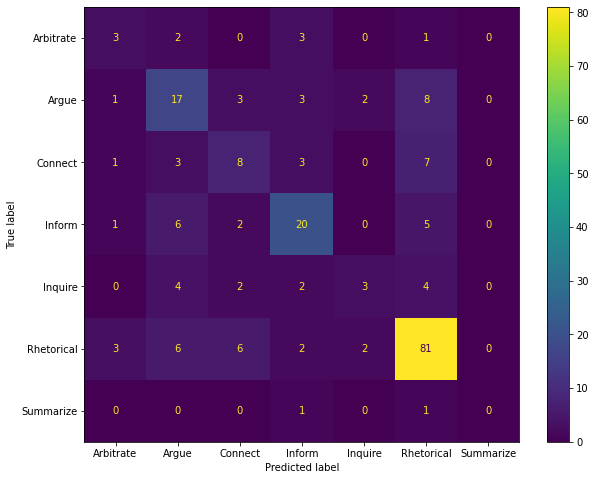



### Arbirate
There were a total of 9 (4.17%) datapoints in the test set with a true authorial intent label of "Arbitrate", with a model accuracy of 3/9 (33%). An equal number of "Arbitrate" authorial intent datapoints were misclassified as the "Inform" authorial intent, signaling that the model finds some commonality between the two intent types. Indeed, given the following failure case:

Feature name | Text
---|---
Article title|Ukraine joins European power grid, ending its dependence on Russia
Parent comment|Ukraine joins European power grid, ending its dependence on Russia
Child comment|Hey /u/Picture-unrelated, This is now the top post on reddit. It will be recorded at /r/topofreddit with all the other top posts.

The child comment is providing information, but the information isn't related to the content of the post; rather, it's related to the metadata about the post i.e. that it will be recorded in "/r/topofreddit".

The model is able to ascertain that intent of the child comment is partially informative, but it isn't able to distinguish between whether the information is related to the content of the post or the metadata of the post.

### Argue
There were a total of 34 (15.74%) datapoints in the test set with a true authorial intent label of "Argue", with a model accuracy of 17/34 (50%). 8/34 (23.52%) of "Argue" authorial intent datapoints were misclassified as "Rhetorical". An example of a failure case is as follows:

Feature name | Text
---|---
Article title|'Price gouging from Covid': student ebooks costing up to 500% more than in print - Call for inquiry into academic publishers as locked-down students unable to access study material online
Parent comment|'Price gouging from Covid': student ebooks costing up to 500% more than in print - Call for inquiry into academic publishers as locked-down students unable to access study material online
Child comment|And that’s why I don’t feel bad pirating as many books as I can. Fuck the required online workbook apps connected to some textbooks though. Scams within scams.

The child comment cites the parent comment as evidence for their point that the author "[doesn't] feel bad pirating as many books as I can." While this is argumentative because the author provides a stance on a topic and provides evidence, the main authorial intent is still rhetorical because the author follows up with "Fuck the ...". 

The model is able to understand the concept of an argument and recognizes it here, but it isn't able to fully understand that while there is an argument presented, the main intent here is to be rhetorical.

### Connect
There were a total of 22 (10.19%) datapoints in the test set with a true authorial intent label of "Connect", with a model accuracy of 8/22 (36.36%). 7/22 (23.52%) of "Connect" authorial intent datapoints were misclassified as "Rhetorical". An example of a failure case is as follows:

Feature name | Text
---|---
Article title|"Churchill's grandson slams Trump for skipping cemetery visit because of weather: ""They died with their face to the foe and that pathetic inadequate @realDonaldTrump couldn’t even defy the weather to pay his respects to The Fallen,"" Soames tweeted
Parent comment|Churchill's grandson slams Trump for skipping cemetery visit because of weather: ""They died with their face to the foe and that pathetic inadequate @realDonaldTrump couldn’t even defy the weather to pay his respects to The Fallen,"" Soames tweeted
Child comment|Again, Imagine Obama. Not just what he would have done in this situation, but what would have happened if he'd acted like *this.*"

The child comment draws parallels between Trump's behavior and Obama's behavior. While the comment does make a rhetorical comment about behavior i.e. "... he'd acted like *this.*", it pertains only to Obama's behavior, not Trump's behavior. 

The model is able to recognize that the intent given the connection reference to Obama is rhetorical, but it's not able to recognize that the comment is topical towards Obama specifically, either because it was not able to coresolve the referent of "he'd" or because the model wasn't able to understand that a connection to new information was made.

### Inform
There were a total of 34 (15.74%) datapoints in the test set with a true authorial intent label of "Connect", with a model accuracy of 20/34 (58.82%). The majority of datapoints were classified correctly, with some datapoints being misclassified as the "Argue" or "Rhetorical" authorial intents.

### Inquire
There were a total of 15 (6.94%) datapoints in the test set with a true authorial intent label of "Inquire", with a model accuracy of 4/15 (26.67%). There was no majority classification label of the datapoints in the test set with true authorial intent label of "Inquire". As such, the model did not learn this class well, if at all, as performance is close to chance.

### Rhetorical
The majority of datapoints were in this class, accounting for 100/216 (46.29%) of the test set datapoints. The model largely classified these datapoints correctly, with an exact match accuracy on the test set of 81/100 (81%). 

### Summarize
There were a total of 2 (0.93%) datapoints in the test set with a true authorial intent label of "Summarize". The model had a 0% accuracy rate on the test set "Summarize" datapoints. As that is a very small proportion of data in the overall datapoint distribution, the model did not learn this class well, if at all. There are not enough datapoints in the test set to tell whether the model performed better than chance. 